In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import simpson

In [2]:
# Constants
NA = 6.02214076E23  # Avogadro's number

In [3]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


## bootstrap for uncertainities

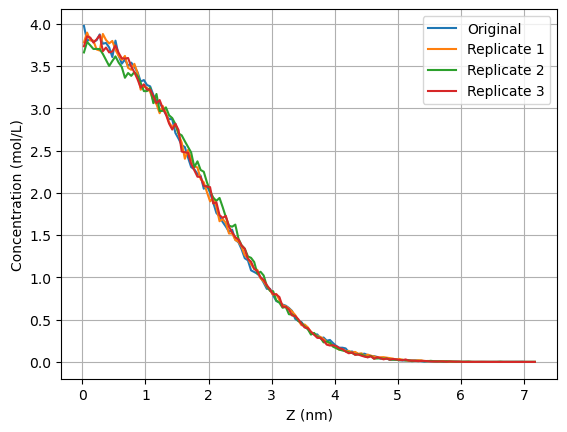

In [4]:
z_0, c_original = compute_c_profile("density_hw_original_288.xvg")
z_1, c_1 = compute_c_profile("density_hw_r1_288.xvg")  # replicate 1
z_2, c_2 = compute_c_profile("density_hw_r2_288.xvg")  # replicate 2
z_3, c_3 = compute_c_profile("density_hw_r3_288.xvg")  # replicate 3

# z_0, c_original = compute_c_profile("density_hwl.xvg")
# z_1, c_1 = compute_c_profile("density_hwr1.xvg")  # replicate 1
# z_2, c_2 = compute_c_profile("density_hwr2.xvg")  # replicate 2
# z_3, c_3 = compute_c_profile("density_hwr3.xvg")  # replicate 3

# Plot the concentration profiles
plt.figure()
plt.plot(z_0, c_original, label="Original")
plt.plot(z_1, c_1, label="Replicate 1")
plt.plot(z_2, c_2, label="Replicate 2")
plt.plot(z_3, c_3, label="Replicate 3")
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()


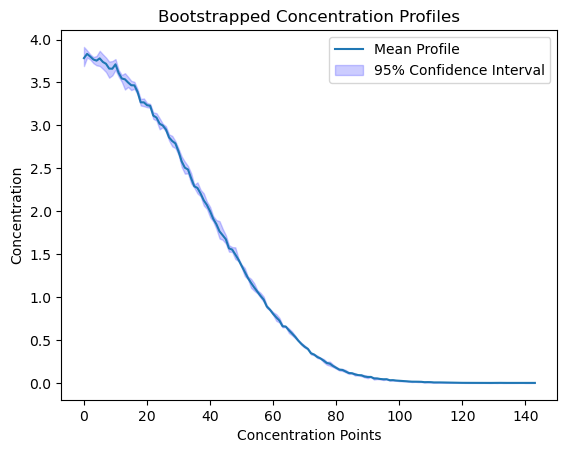

In [5]:
# Example concentration profiles
concentration_profiles = [c_original,c_1,c_2,c_3]

# Number of bootstrap samples
n_bootstrap = 1000

# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples):
    bootstrap_means = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        bootstrap_means.append(mean_profile)
    return np.array(bootstrap_means)

# Perform bootstrapping
bootstrap_means = bootstrap_profiles(concentration_profiles, n_bootstrap)

# Calculate the mean and 95% confidence intervals for each point
mean_profile = np.mean(bootstrap_means, axis=0)
lower_bound = np.percentile(bootstrap_means, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_means, 97.5, axis=0)

c_0=mean_profile

# Plotting the results
conc_points = range(len(c_0))
plt.plot(conc_points, c_0, label='Mean Profile')
plt.fill_between(conc_points, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Concentration Points')
plt.ylabel('Concentration')
plt.legend()
plt.title('Bootstrapped Concentration Profiles')
plt.show()

/tmp/ipykernel_109690/3808519112.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(z_0, np.log(c_0), label='Mean Profile')


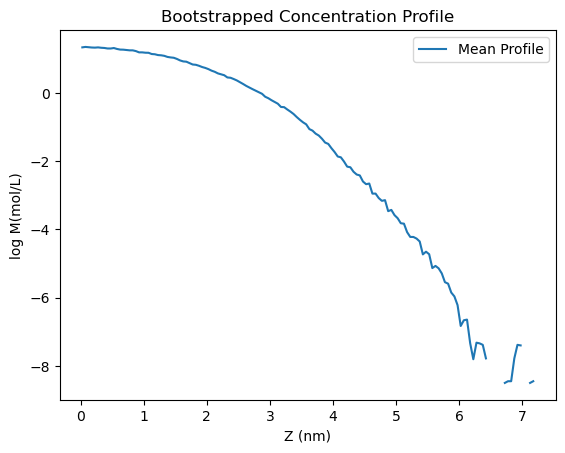

In [6]:
# Plotting the results
plt.plot(z_0, np.log(c_0), label='Mean Profile')
plt.xlabel('Z (nm)')
plt.ylabel('log M(mol/L)')
plt.legend()
plt.title('Bootstrapped Concentration Profile')
plt.show()

In [7]:
# Estimate the total number of ions, N_s (using Equation 13)
L_x, L_y, L_z = 4.8, 4.8, 14.4
N_s = L_x * L_y * simpson(c_0, z_0)
print(N_s)  # this should be around 188

188.07067196602142


/tmp/ipykernel_109690/2582005041.py:3: DeprecationWarning: You are passing x=[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125 1.175
 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575 1.625 1.675 1.725 1.775
 1.825 1.875 1.925 1.975 2.025 2.075 2.125 2.175 2.225 2.275 2.325 2.375
 2.425 2.475 2.525 2.575 2.625 2.675 2.725 2.775 2.825 2.875 2.925 2.975
 3.025 3.075 3.125 3.175 3.225 3.275 3.325 3.375 3.425 3.475 3.525 3.575
 3.625 3.675 3.725 3.775 3.825 3.875 3.925 3.975 4.025 4.075 4.125 4.175
 4.225 4.275 4.325 4.375 4.425 4.475 4.525 4.575 4.625 4.675 4.725 4.775
 4.825 4.875 4.925 4.975 5.025 5.075 5.125 5.175 5.225 5.275 5.325 5.375
 5.425 5.475 5.525 5.575 5.625 5.675 5.725 5.775 5.825 5.875 5.925 5.975
 6.025 6.075 6.125 6.175 6.225 6.275 6.325 6.375 6.425 6.475 6.525 6.575
 6.625 6.675 6.725 6.775 6.825 6.875 6.925 6.975 7.025 7.075 7.125 7.175] as a positional argument. Please change your i

In [8]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    term_4 = (alpha_1 * (x - C_max)) + (alpha_2 * (x ** 2 - C_max ** 2))

    y = term_1 + term_2 + term_3 + term_4

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [9]:
def y_ideal(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    # term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    # term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    # term_4 = (alpha_1 * (x - C_max)) + (alpha_2 * (x ** 2 - C_max ** 2))

    return term_1

def residuals_ideal(theta, x, y):
    return np.power(y_ideal(theta, x) - y, 2)

In [10]:
# Removing 0 values from the concentration profile, and the corresponding z values
z_0 = z_0[c_0 != 0]
c_0 = c_0[c_0 != 0]

# Calculating -U(z) / RT (y_values below)
k = 1.0457  # units: kJ/mol/nm^2
R = 8.31446261815324  # units: J/(mol*K)
T = 300  # units: K
y_values = -(0.5 * k * z_0 ** 2) * 1000 / (R * T)

result = least_squares(residuals, [2, 0.1, 0.3], args=(c_0, y_values))
result_ideal = least_squares(residuals_ideal, [2, 0.1, 0.3], args=(c_0, y_values))

# # B, alpha_1, and alpha_2 have units of [nm^(-3)]^(-1/2), [nm^(-3)]^(-1), and [nm^(-3)]^(-2)
# B, alpha_1, alpha_2 = result.x[0], result.x[1], result.x[2]

# # Converting nm^(-3) to mol/L for the three parameters
# conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
# B *= (conversion_factor ** (-0.5))  # units M^(-1/2)
# alpha_1 *= (conversion_factor ** (-1))  # units M^(-1)
# alpha_2 *= (conversion_factor ** (-2))  # units M^(-2)

def get_results(result_fit):
    result=result_fit
    # B, alpha_1, and alpha_2 have units of [nm^(-3)]^(-1/2), [nm^(-3)]^(-1), and [nm^(-3)]^(-2)
    B, alpha_1, alpha_2 = result.x[0], result.x[1], result.x[2]
    # Converting nm^(-3) to mol/L for the three parameters
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    B *= (conversion_factor ** (-0.5))  # units M^(-1/2)
    alpha_1 *= (conversion_factor ** (-1))  # units M^(-1)
    alpha_2 *= (conversion_factor ** (-2))  # units M^(-2)
    print("B=",B,'alpha1=',alpha_1,'alpha2=', alpha_2)
    newtheta=(B, alpha_1, alpha_2)
    return newtheta

In [11]:
newtheta=get_results(result)

B= 12.678716891227827 alpha1= -0.04374056873824547 alpha2= 0.013618955477540043


In [12]:
idealtheta=get_results(result_ideal)

B= 1.5520490662346986 alpha1= 0.0602214076 alpha2= 0.10879853799976014


In [13]:
# print(result.x)
# print(result.cost)
# print(result.optimality)

In [14]:
# print(B, alpha_1, alpha_2)
# newtheta=(B, alpha_1, alpha_2)

In [15]:
# # nm-based answers
# print(1.9247 / (conversion_factor ** (-0.5)))
# print(9.3393E-2 / (conversion_factor ** (-1)))
# print(3.4572E-2 / (conversion_factor **(-2)))

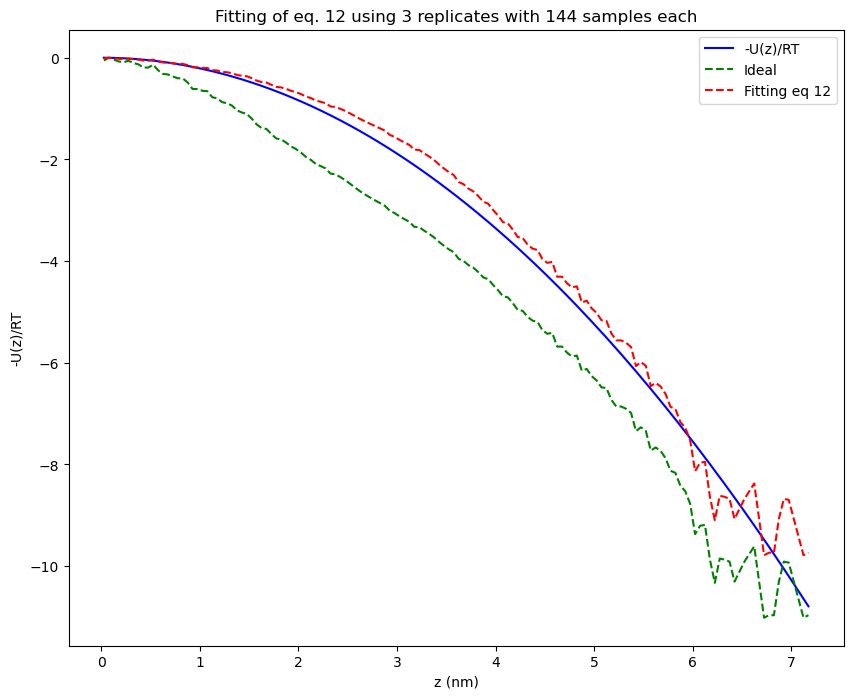

In [16]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_0, y_values, 'b', label="-U(z)/RT")
plt.plot(z_0, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_0, calc_y(newtheta,c_0), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()